# cygnus-threshold-sweep

Sweep Cygnus width Q-value threshold at 3200 MT/s and 200 MT/s.

10/31/2023

In [1]:
from collections import defaultdict
from importlib import reload
import json
import os
import sys
from typing import Dict, List, Optional

from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../../"))
from plot_utils import collate, plot
from naboo_utils import table

# Configuration

In [2]:
sim_dir = "/u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/"
baseline_study = "baseline"
baseline_experiment = "_baseline"
bandwidths = [200, 3200]
weights_path = "/u/cmolder/GitHub/ChampSim-2022/external/naboo/conf/weights.toml"

suites = [
    "spec06",
    "spec17",
    "gap",
    "cloudsuite",
]
dpi = 192

In [3]:
reload(collate)
studies = {}
for bandwidth in bandwidths:
    print(f"\n=== {bandwidth} MT/s ===")
    core_str = f"default_{bandwidth}"
    core_dir = os.path.join(sim_dir, core_str)

    # Threshold sweep
    print(f"~~~ {os.path.join(core_dir, 'cygnus_qvthreshold')} ~~~")
    studies[f"cygnus_qvthreshold__{bandwidth}"] = collate.StudyCollator(
        core_dir, "cygnus_qvthreshold",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
    )

    # Baselines
    print(f"~~~ {os.path.join(core_dir, 'prefetchers')} ~~~")
    studies[f"prefetchers__{bandwidth}"] = collate.StudyCollator(
        core_dir, "prefetchers",
        baseline_study=baseline_study,
        baseline_experiment=baseline_experiment,
        weights_path=weights_path,
        experiments=["spp_ppf", "pythia", "my5"],
    )


=== 200 MT/s ===
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/cygnus_qvthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3395/3395 [00:42<00:00, 80.50file/s] 


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_200/prefetchers ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 1129/1129 [00:07<00:00, 145.57file/s]


[ipykernel_launcher][angrist-3] Collating study files...

=== 3200 MT/s ===
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/cygnus_qvthreshold ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 3395/3395 [00:44<00:00, 76.76file/s] 


[ipykernel_launcher][angrist-3] Collating study files...
~~~ /u/cmolder/GitHub/ChampSim-2022/sim/dram_dramsim3_2022/default_3200/prefetchers ~~~


[ipykernel_launcher][angrist-3] Reading study files: 100%|██████████| 1129/1129 [00:08<00:00, 135.73file/s]


[ipykernel_launcher][angrist-3] Collating study files...


# Helper functions

In [143]:
def table_threshold_sweep_suite(data: Dict[int, dict],
                                statistic_name: str = "cpu.gmean.ipc_improvement",
                                suites: Optional[List[str]] = None,
                                add_mean: bool = False):
    table = plot.get_suite_table(data, statistic_name,
                                 suites=suites, add_mean=add_mean)
    return table

def table_threshold_sweep_benchmark(data: Dict[int, dict],
                                    suite: str,
                                    benchmarks: Optional[List[str]] = None,
                                    statistic_name: str = "cpu.gmean.ipc_improvement",
                                    add_mean: bool = False):
    table = plot.get_benchmark_table(data, suite, statistic_name,
                                     add_mean=add_mean)
    if benchmarks is not None:
        table = table[benchmarks]
    return table

def table_threshold_sweep_trace(data: Dict[int, dict],
                                suite: str,
                                traces: Optional[List[str]] = None,
                                statistic_name: str = "cpu.gmean.ipc_improvement"):
    table = plot.get_trace_table(data, suite, statistic_name)

    if traces is not None:
        table = table[traces]
    return table

def plot_threshold_table(table: pd.DataFrame,
                         ymin: Optional[float] = None,
                         ymax: Optional[float] = None,
                         colors: Optional[dict] = defaultdict(lambda: None),
                         markers: Optional[dict] = defaultdict(lambda: "o"),
                         legend_kwargs: Optional[dict] = {},
                         suptitle: Optional[str] = None,
                         ylabel: Optional[str] = None):
    # Plot
    fig, ax = plt.subplots(figsize=(5, 3), dpi=dpi)

    for col in table.columns:
        X = table.index.to_numpy(dtype=np.float32)
        y = table[col].to_numpy(dtype=np.float32)
        
        ax.plot(X, y, label=col, marker='.', markersize=5)

    ax.grid(axis='both', color='lightgray')
    # ax.set_ylim(ymin=ymin, ymax=ymax)
    #ax.set_xticks(range(len(data.keys())))
    #ax.set_xticklabels(data.keys())
    ax.set_ylim(ymin=ymin, ymax=ymax)

    # ax.xaxis.set_tick_params(labelsize=7.5)
    # ax.yaxis.set_tick_params(labelsize=7.5)

    ax.set_xlabel("Q-value threshold", fontsize=7.5)
    ax.set_ylabel(ylabel, fontsize=7.5)
    
    ax.set_title(suptitle)#, fontsize=7.5)
    fig.legend(**legend_kwargs)
    fig.tight_layout()

def plot_threshold_sweep(data: Dict[int, dict],
                         statistic_name: str = "cpu.gmean.ipc_improvement",
                         suites: Optional[List[str]] = None,
                         **kwargs):
    # Get statistics
    table = table_threshold_sweep_suite(data, 
                                        statistic_name=statistic_name,
                                        suites=suites, 
                                        add_mean=True)
    plot_threshold_table(table, **kwargs)

def plot_threshold_sweep_benchmarks(data: Dict[int, dict],
                                    statistic_name: str = "cpu.gmean.ipc_improvement",
                                    suite: str = "spec06",
                                    benchmarks: Optional[List[str]] = None,
                                    **kwargs):

    # Get statistics
    table = table_threshold_sweep_benchmark(data, suite,
                                            benchmarks=benchmarks,
                                            statistic_name=statistic_name,
                                            add_mean=False)
    plot_threshold_table(table, **kwargs)

def create_oracle(tabler: table.ChampsimTabler, 
                  oracle_stat: str, 
                  oracle_level: str = "mix", 
                  oracle_method: str = "max",
                  oracle_experiments: Optional[List[str]] = None,):
    """Generate an Oracle.
    """

    oracle_stat_df = None
    if oracle_level == "mix":
        oracle_stat_df = tabler.table_statistic_mix(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "benchmark":
        oracle_stat_df = tabler.table_statistic_benchmark(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "suite":
        oracle_stat_df = tabler.table_statistic_suite(oracle_stat, experiments=oracle_experiments).T
    elif oracle_level == "overall":
        oracle_stat_df = tabler.table_statistic_overall(oracle_stat, experiments=oracle_experiments).to_frame().T
    else:
        raise NotImplementedError
    
    # Stitch the oracle together
    if oracle_method == "max":
        oracle_value_s = oracle_stat_df.max(axis=1)
        oracle_experiment_s = oracle_stat_df.idxmax(axis=1)
    elif oracle_method == "min":
        oracle_value_s = oracle_stat_df.min(axis=1)
        oracle_experiment_s = oracle_stat_df.idxmin(axis=1)
    else:
        raise NotImplementedError
    
    oracle_df = pd.DataFrame({
        "Value": oracle_value_s,
        "Experiment": oracle_experiment_s
    })
    
    # Return the oracle
    from IPython.display import display
    return oracle_df

def get_oracle_stat(tabler: table.ChampsimTabler, 
                    oracle_df: pd.DataFrame, # Which trace maps to which experiment
                    stat_level: str, # Assumes oracle is per-mix, for now.
                    stat: str,
                    oracle_experiments: Optional[List[str]] = None):
    mix_df = tabler.table_statistic_mix(stat, experiments=oracle_experiments).T
    oracle_s = oracle_df["Experiment"]

    mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
    mix_oracle_df = mix_df[["Oracle"]].T
    
    # Compute to the right stat level using the tabler.
    if stat_level == "mix":
        return mix_oracle_df
    
    # Benchmark
    benchmark_oracle_df = tabler.table_statistic_benchmark_(
        stat, mix_oracle_df, ["Oracle"], tabler.get_benchmarks(), 
        use_weights=True)
    if stat_level == "benchmark":
        return benchmark_oracle_df
    
    # Suite
    suite_oracle_df = tabler.table_statistic_suite_(
        stat, benchmark_oracle_df, ["Oracle"], tabler.get_suites())
    if stat_level == "suite":
        return suite_oracle_df
    
    # Overall
    overall_oracle_df = tabler.table_statistic_overall_(
        stat, suite_oracle_df, ["Oracle"])
    if stat_level == "overall":
        return overall_oracle_df
    
    raise NotImplementedError

In [145]:
# # [TESTING]
# thresholds = [int(exp.split("_")[-1]) for exp in studies[f"cygnus_qvthreshold__{bandwidth}"].study.experiments]

# threshold_oracle = create_oracle(
#     studies["cygnus_qvthreshold__3200"].tabler,
#     "cpu.gmean.ipc_improvement",
#     oracle_level="mix",
#     oracle_method="max",
#     oracle_experiments=[f"cygnus__{t}" for t in thresholds]
# )

# threshold_oracle__ipc__mix= get_oracle_stat(
#     studies["cygnus_qvthreshold__3200"].tabler,
#     threshold_oracle,
#     "mix",
#     "cpu.gmean.ipc_improvement",
#     oracle_experiments=[f"cygnus__{t}" for t in thresholds]
# )

# threshold_oracle__ipc__benchmark = get_oracle_stat(
#     studies["cygnus_qvthreshold__3200"].tabler,
#     threshold_oracle,
#     "benchmark",
#     "cpu.gmean.ipc_improvement",
#     oracle_experiments=[f"cygnus__{t}" for t in thresholds]
# )

# threshold_oracle__ipc__suite = get_oracle_stat(
#     studies["cygnus_qvthreshold__3200"].tabler,
#     threshold_oracle,
#     "suite",
#     "cpu.gmean.ipc_improvement",
#     oracle_experiments=[f"cygnus__{t}" for t in thresholds]
# )

# threshold_oracle__ipc__overall = get_oracle_stat(
#     studies["cygnus_qvthreshold__3200"].tabler,
#     threshold_oracle,
#     "overall",
#     "cpu.gmean.ipc_improvement",
#     oracle_experiments=[f"cygnus__{t}" for t in thresholds]
# )

# # from IPython.display import display
# # display(threshold_oracle__ipc__mix.T)
# # display(threshold_oracle__ipc__benchmark.T)
# # display(threshold_oracle__ipc__suite.T)
# # display(threshold_oracle__ipc__overall.T)

/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] =

# Threshold sweep tables

In [5]:
degreedyn_1core_dfs = {}
for bandwidth in bandwidths:
    degreedyn_1core_dfs[bandwidth] = {}
    thresholds = [int(exp.split("_")[-1]) for exp in studies[f"cygnus_qvthreshold__{bandwidth}"].study.experiments]
    degreedyn_1core_dfs[bandwidth] = {
        threshold: studies[f"cygnus_qvthreshold__{bandwidth}"][f"cygnus__{threshold}"] for threshold in thresholds
    }

degreedyn_1core_legend_kwargs = {
    "ncol": 6,
    "fontsize": 6.75,
    "loc": "lower center",
    "bbox_to_anchor": (0.5, 1.0),
    "framealpha": 0,
}

## 3200 MT/s

### IPC improvement

In [6]:
table_threshold_sweep_suite(degreedyn_1core_dfs[3200], suites=suites, add_mean=True)

,spec06,spec17,gap,cloudsuite,gmean
-14,27.980512,14.971241,20.272462,2.362852,16.014003
-13,27.972586,14.971241,20.272462,2.362852,16.012206
-12,27.985623,14.971241,20.272462,2.362852,16.015161
-11,27.994744,14.995596,20.270392,2.367814,16.024278
-10,27.883684,15.218542,20.346868,2.404661,16.084172
-9,28.372428,16.248004,20.698672,2.741779,16.634413
-8,30.517070,19.519079,22.543232,4.953143,19.013803
-7,32.133262,22.431458,23.095844,7.880812,21.066279
-6,32.750135,23.548254,22.856726,9.508211,21.879118
-5,33.343997,24.465668,22.568808,10.202619,22.362610


#### spec06

In [7]:
table_threshold_sweep_benchmark(
    degreedyn_1core_dfs[3200], suite="spec06", 
    benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"]
    #benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"]
)

,GemsFDTD,astar,bwaves,cactusADM,gcc,lbm,leslie3d,libquantum
-14,67.509971,-2.068368,38.010008,57.149794,32.591866,50.507456,29.227988,66.090254
-13,67.509971,-2.068368,38.010008,57.149794,32.591866,50.507456,29.227988,66.090254
-12,67.508832,-2.067799,38.010008,57.149794,32.591866,50.507456,29.227988,66.090254
-11,67.542056,-1.947744,37.958026,57.093484,32.591895,50.507456,29.212486,66.090254
-10,67.590798,-1.265653,38.013745,57.044197,32.589652,50.507456,29.556901,66.090254
-9,67.778530,0.468102,38.026485,56.870428,32.615855,50.507456,29.925904,66.090254
-8,70.233739,4.977002,39.106972,59.873622,32.680550,50.464252,30.041518,66.088553
-7,73.000000,8.245829,40.594820,62.293051,32.784773,50.495851,30.443099,66.082929
-6,74.571276,7.097948,40.793207,63.825137,32.808688,50.511438,30.479804,66.067345
-5,75.762626,6.773701,41.172904,65.229207,32.780456,50.492358,30.520883,66.009023


In [8]:
table_threshold_sweep_benchmark(
    degreedyn_1core_dfs[3200], suite="spec06", 
    #benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"]
    benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"]
)

,mcf,milc,omnetpp,soplex,sphinx3,xalancbmk,zeusmp
-14,12.914811,-17.776876,-4.399418,38.181440,59.007292,5.663122,28.883809
-13,12.809846,-17.776876,-4.399328,38.181440,59.007292,5.663122,28.883809
-12,12.911267,-17.776876,-4.339034,38.181440,59.007292,5.663122,28.883809
-11,12.897609,-17.763035,-4.115516,38.181440,59.007292,5.643850,28.665081
-10,14.074731,-17.752733,-3.877251,38.123360,58.987566,5.640507,24.192161
-9,19.293940,-17.719160,-1.038283,38.526443,59.000302,6.132914,18.699761
-8,22.392532,-11.208950,2.749583,39.386023,59.495592,7.262597,19.058796
-7,17.581194,-3.089982,6.806410,40.662744,59.720294,8.724680,18.813483
-6,13.946977,1.660323,10.101002,41.556340,59.935882,9.561451,18.578594
-5,12.651555,4.952753,12.579012,42.161536,60.281399,10.204804,18.265624


#### spec17

In [9]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[3200], suite="spec17")

,602.gcc,605.mcf,607.cactuBSSN,619.lbm,620.omnetpp,623.xalancbmk,627.cam4,628.pop2,649.fotonik3d
-14,66.103874,-13.003232,19.836970,22.584180,-11.223672,-16.223939,2.047436,17.770589,84.985969
-13,66.103874,-13.003232,19.836970,22.584180,-11.223672,-16.223939,2.047436,17.770589,84.985969
-12,66.103874,-13.003232,19.836970,22.584180,-11.223672,-16.223939,2.047436,17.770589,84.985969
-11,66.103874,-13.002016,20.032003,22.584180,-11.223672,-16.234207,2.081236,17.770589,84.996625
-10,66.101324,-13.023271,19.563451,22.573905,-10.643984,-14.600348,1.771526,17.763330,84.804473
-9,66.143138,-12.892227,19.614926,22.605689,-9.223817,-9.317915,2.029321,17.707833,84.761066
-8,66.147997,-9.399373,27.682326,22.632729,-4.162508,-0.726915,1.956904,17.885616,84.640611
-7,66.261432,-1.111892,31.099741,22.654337,1.333130,3.641170,2.211145,18.011421,84.548617
-6,66.416146,1.966115,31.063690,22.738362,4.479755,5.683632,2.125933,18.089352,84.513785
-5,66.601517,4.325794,30.747077,22.597404,7.810636,7.364510,1.875479,18.250277,84.530458


#### gap

In [10]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[3200], suite="gap")

,bc,bfs,cc,pr,sssp,tc
-14,7.107687,64.742065,35.562921,4.268254,2.732290,18.133226
-13,7.107687,64.742065,35.562921,4.268254,2.732290,18.133226
-12,7.107687,64.742065,35.562921,4.268254,2.732290,18.133226
-11,7.120374,64.742065,35.562921,4.268254,2.709518,18.133226
-10,7.236704,64.741247,35.476733,4.279033,2.871253,18.333362
-9,7.944738,64.775111,35.398515,4.236695,3.504177,18.995200
-8,12.199106,65.088491,35.336482,4.110363,7.965331,20.181224
-7,13.819260,65.028440,35.339027,4.035197,9.080020,20.597206
-6,13.522530,64.689619,35.287953,3.749024,8.549557,20.718586
-5,12.765301,64.331093,35.267550,3.422741,8.233878,20.840264


#### cloudsuite

In [11]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[3200], suite="cloudsuite")

,cassandra,classifcation,cloud9,nutch
-14,0.323639,-28.076943,27.680493,19.171813
-13,0.323639,-28.076943,27.680493,19.171813
-12,0.323639,-28.076943,27.680493,19.171813
-11,0.323639,-28.076943,27.696256,19.180210
-10,0.349077,-28.081779,27.848200,19.187842
-9,0.731185,-27.838271,28.493506,19.298855
-8,3.049035,-23.783423,29.285764,19.491693
-7,6.182059,-17.142612,28.590693,19.725015
-6,7.804886,-13.475532,28.408675,20.064602
-5,8.876165,-12.109014,28.073769,20.345628


## 200 MT/s

### IPC improvement

In [12]:
table_threshold_sweep_suite(degreedyn_1core_dfs[200], suites=suites, add_mean=True)

,spec06,spec17,gap,cloudsuite,gmean
-14,-16.921288,-16.482079,-11.879371,-42.570075,-23.021168
-13,-16.916773,-16.482079,-11.879371,-42.570075,-23.020122
-12,-17.012023,-16.474550,-11.879371,-42.572067,-23.041128
-11,-17.034349,-16.416267,-11.884489,-42.556019,-23.028625
-10,-15.678261,-15.684981,-11.137992,-42.505067,-22.366789
-9,-13.520683,-12.752277,-5.284757,-41.521728,-19.597382
-8,-10.096900,-7.137924,4.414454,-36.528567,-13.754192
-7,-6.919981,-3.087383,10.006916,-28.205798,-8.127288
-6,-4.544233,-0.571461,13.141311,-21.720517,-4.248498
-5,-2.995889,2.086223,15.912820,-17.431885,-1.332238


#### spec06

In [13]:
table_threshold_sweep_benchmark(
    degreedyn_1core_dfs[200], suite="spec06", 
    benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"]
    #benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"]
)

,GemsFDTD,astar,bwaves,cactusADM,gcc,lbm,leslie3d,libquantum
-14,-9.646028,-29.222388,11.558378,30.120112,-4.270093,5.615663,2.427968,20.625878
-13,-9.647186,-29.222388,11.558378,30.120112,-4.270093,5.615663,2.427968,20.625878
-12,-9.773777,-29.222981,11.558378,30.120112,-4.270093,5.615663,2.427968,20.625878
-11,-9.784341,-28.939696,11.559331,30.157404,-4.261160,5.615663,2.426808,20.625878
-10,-10.034216,-23.257198,11.577328,30.699051,-4.281644,5.615663,2.450523,20.625878
-9,-9.387150,-16.445356,11.590021,30.969488,-4.245047,5.615663,2.503488,20.625878
-8,-6.923930,-1.302679,11.720755,31.098559,-4.128546,5.619488,2.545356,20.625878
-7,-5.486275,6.987936,11.773529,31.122481,-3.746786,5.628337,2.591837,20.677725
-6,-4.414692,7.065604,11.775723,31.127070,-3.484617,5.624358,2.609957,20.677725
-5,-3.533065,6.947521,11.792879,31.092112,-3.060337,5.619201,2.622192,20.660223


In [14]:
table_threshold_sweep_benchmark(
    degreedyn_1core_dfs[200], suite="spec06", 
    #benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"]
    benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"]
)

,mcf,milc,omnetpp,soplex,sphinx3,xalancbmk,zeusmp
-14,-48.572277,-48.327186,-57.487967,-19.035804,-25.180055,-36.886250,23.770129
-13,-48.567357,-48.327186,-57.488148,-19.035804,-25.180055,-36.886250,23.861346
-12,-48.551737,-48.327186,-57.430072,-19.035804,-25.180055,-36.899915,21.743258
-11,-48.262778,-48.326735,-57.188988,-19.037245,-25.180055,-36.895593,19.380572
-10,-40.991545,-48.342320,-56.616496,-19.038423,-25.184973,-36.818716,21.680684
-9,-27.304586,-48.564624,-54.839562,-18.840217,-25.191818,-35.889360,24.426244
-8,-13.495891,-45.064751,-50.677159,-18.165625,-24.965878,-33.522607,25.646539
-7,-1.676720,-36.889569,-46.158223,-17.129455,-24.841803,-29.904447,25.349211
-6,1.732774,-25.682794,-40.934649,-16.017509,-24.635832,-25.517234,24.876834
-5,2.171428,-21.947015,-34.737373,-14.746257,-24.318349,-21.141657,24.832358


#### spec17

In [15]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[200], suite="spec17")

,602.gcc,605.mcf,607.cactuBSSN,619.lbm,620.omnetpp,623.xalancbmk,627.cam4,628.pop2,649.fotonik3d
-14,81.450051,-60.084770,10.864261,2.789886,-60.957308,-43.060939,0.039046,4.867471,2.711483
-13,81.450051,-60.084770,10.864261,2.789886,-60.957308,-43.060939,0.039046,4.867471,2.711483
-12,81.450051,-60.084770,10.864261,2.789886,-60.957308,-43.014727,0.039046,4.867471,2.711483
-11,81.450051,-60.089909,10.802875,2.789886,-60.958612,-42.602988,0.017423,4.867471,2.712587
-10,81.458781,-60.117429,13.110711,2.791659,-60.645459,-39.626961,-0.063421,4.946857,2.704615
-9,81.648923,-56.573884,11.293304,2.794698,-56.181989,-31.245642,-0.017995,4.932464,2.701959
-8,82.296729,-47.762012,8.620073,2.786083,-49.278074,-11.693805,-0.119447,5.110394,2.712257
-7,82.878977,-36.351093,6.081668,2.787464,-43.216366,-3.286221,0.027213,5.284768,2.728850
-6,84.081651,-28.908319,3.562165,2.795146,-36.845219,-0.482971,0.082841,5.495755,2.730226
-5,85.822213,-22.070681,2.452880,2.785806,-28.513384,1.645346,0.082651,5.704854,2.726483


#### gap

In [16]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[200], suite="gap")

,bc,bfs,cc,pr,sssp,tc
-14,-43.943815,-8.385316,79.624500,9.617444,-43.390110,-18.202625
-13,-43.943815,-8.385316,79.624500,9.617444,-43.390110,-18.202625
-12,-43.943815,-8.385316,79.624500,9.617444,-43.390110,-18.202625
-11,-43.941045,-8.385316,79.618421,9.617444,-43.410719,-18.202625
-10,-43.623204,-8.385545,80.737829,9.921986,-43.109105,-15.655657
-9,-35.146335,-8.216496,81.541697,10.090691,-38.351054,-1.560936
-8,-24.169092,-7.373483,82.235102,10.199506,-23.870529,20.675096
-7,-14.398086,-6.681338,82.452291,10.132808,-14.624308,29.320590
-6,-6.241337,-5.790652,82.600268,9.588141,-10.614377,32.766711
-5,0.897776,-4.386753,82.657954,9.110325,-7.116863,35.815035


#### cloudsuite

In [17]:
table_threshold_sweep_benchmark(degreedyn_1core_dfs[200], suite="cloudsuite")

,cassandra,classifcation,cloud9,nutch
-14,-54.140467,-74.257273,-11.828859,4.506271
-13,-54.140467,-74.257273,-11.828859,4.506271
-12,-54.140467,-74.257273,-11.841348,4.506575
-11,-54.147056,-74.257273,-11.764286,4.547091
-10,-54.130236,-74.277362,-11.515843,4.667235
-9,-52.295036,-74.028219,-10.052095,4.935340
-8,-46.839930,-68.780405,-7.219583,5.400846
-7,-41.709469,-55.242334,-3.971872,6.045824
-6,-36.692318,-44.230448,-0.771361,7.176901
-5,-31.927970,-38.797603,2.845679,8.474162


# Threshold sweep plots

## 3200 MT/s

### IPC improvement

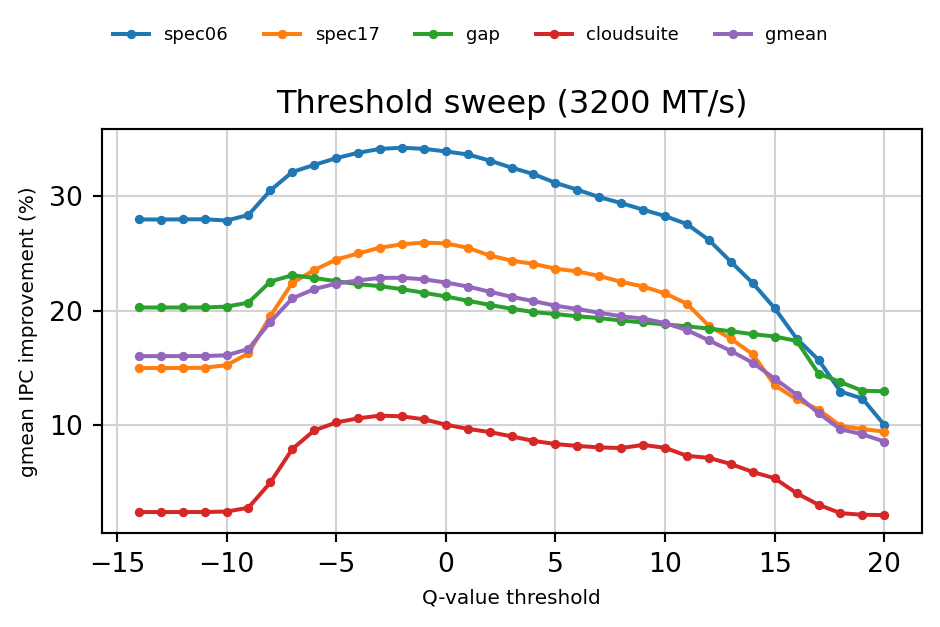

In [18]:
plot_threshold_sweep(
    degreedyn_1core_dfs[3200], 
    suites=suites, 
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    #ymin=0,
)
plt.savefig("threshold_sweep_3200_ipc.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc.png", dpi=dpi, bbox_inches="tight")

#### spec06

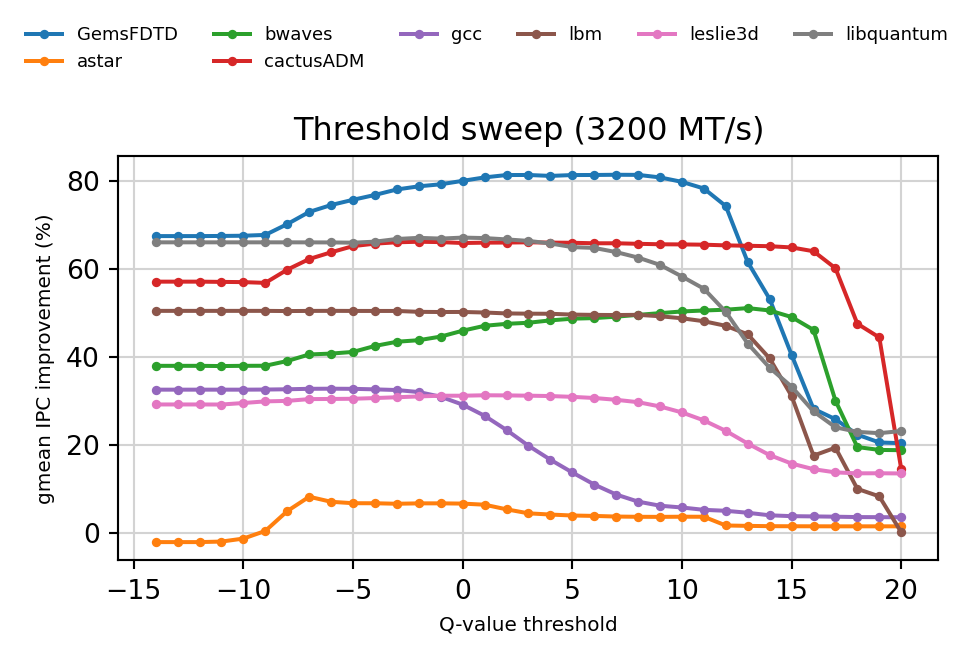

In [19]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[3200], 
    suite="spec06",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"],
)
plt.savefig("threshold_sweep_3200_ipc_spec06.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc_spec06.png", dpi=dpi, bbox_inches="tight")

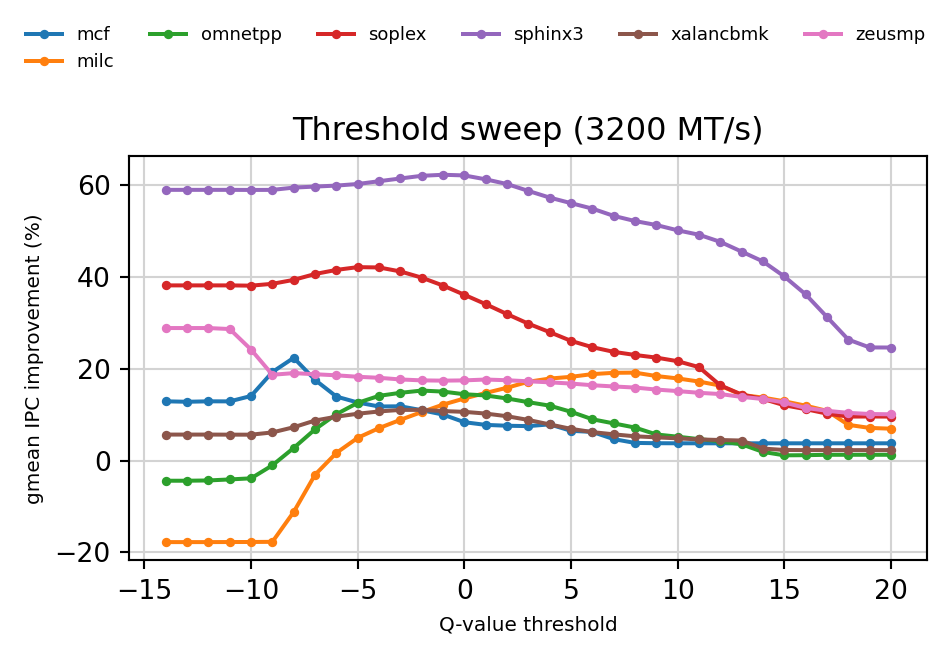

In [20]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[3200], 
    suite="spec06",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"],
)
plt.savefig("threshold_sweep_3200_ipc_spec06_pt2.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc_spec06_pt2.png", dpi=dpi, bbox_inches="tight")

#### spec17

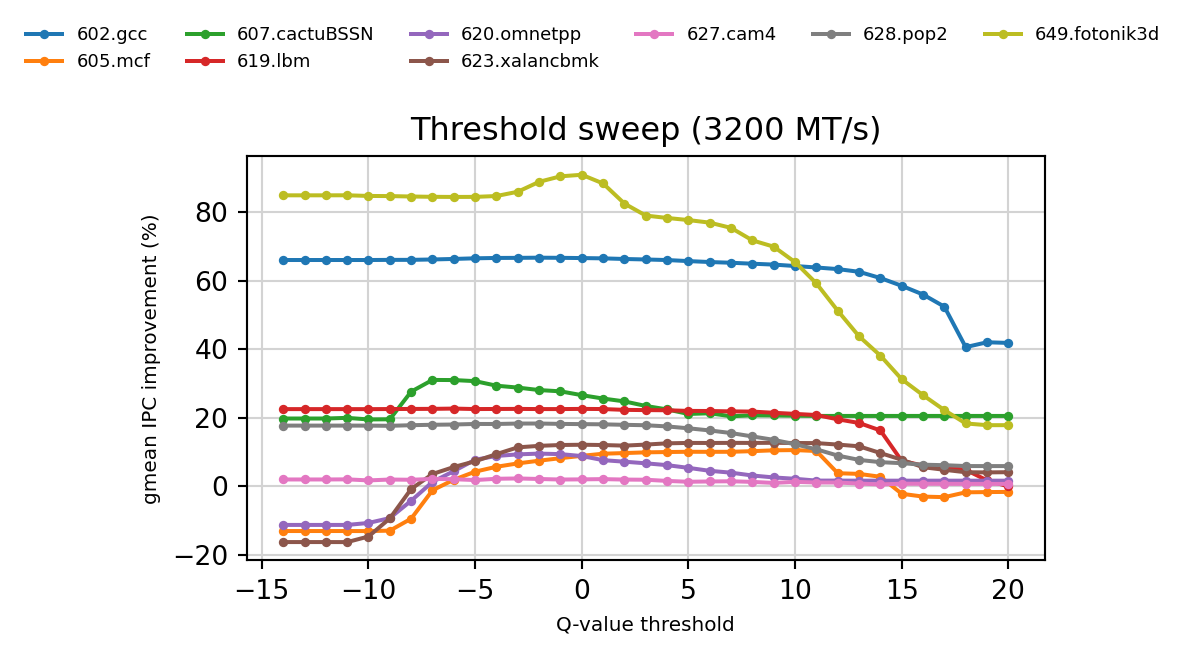

In [21]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[3200], 
    suite="spec17",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
)
plt.savefig("threshold_sweep_3200_ipc_spec17.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc_spec17.png", dpi=dpi, bbox_inches="tight")

#### gap

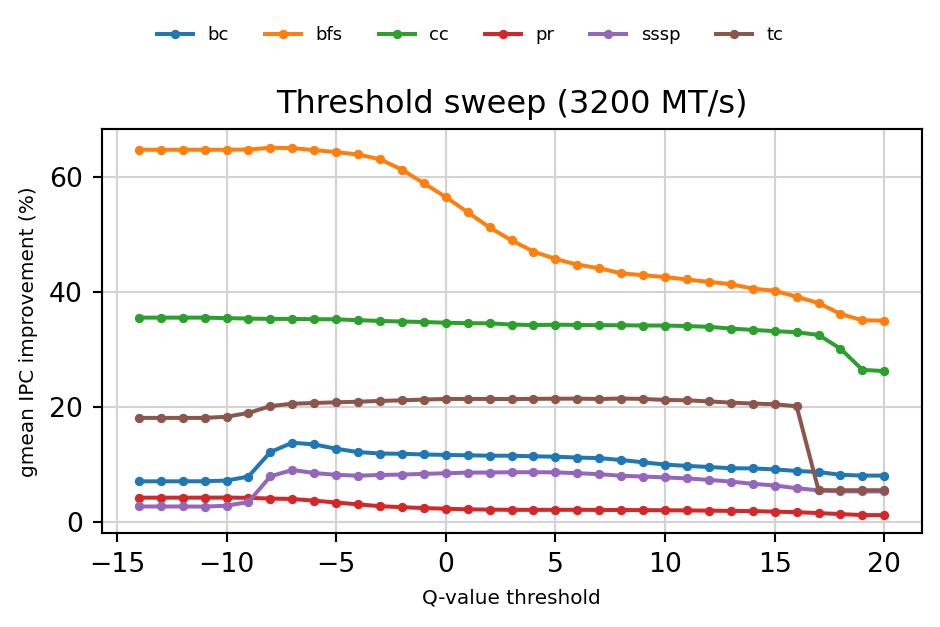

In [22]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[3200], 
    suite="gap",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
)
plt.savefig("threshold_sweep_3200_ipc_gap.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc_gap.png", dpi=dpi, bbox_inches="tight")

#### cloudsuite

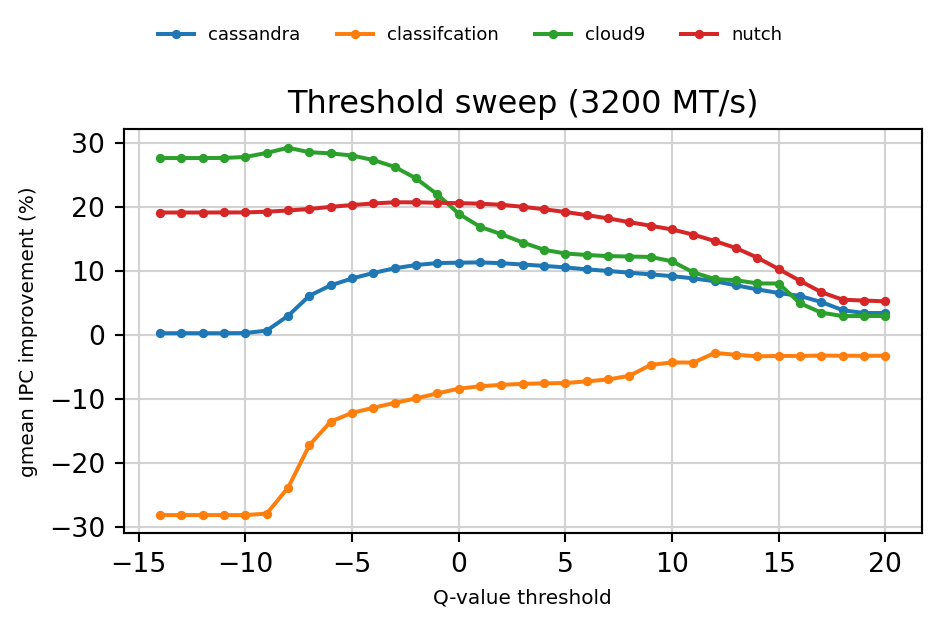

In [23]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[3200], 
    suite="cloudsuite",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (3200 MT/s)",
)
plt.savefig("threshold_sweep_3200_ipc_cloudsuite.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_ipc_cloudsuite.png", dpi=dpi, bbox_inches="tight")

### Coverage

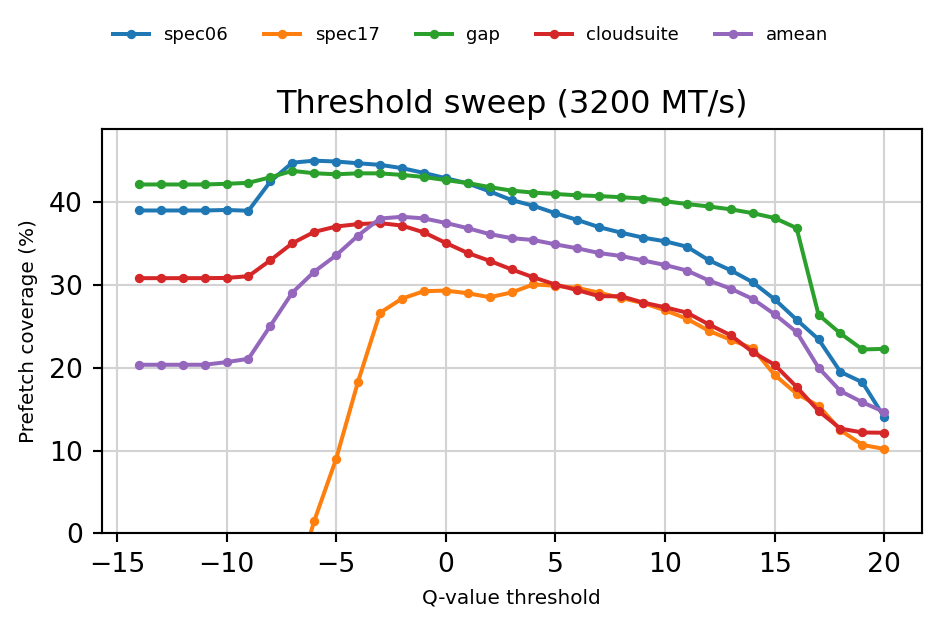

In [24]:
plot_threshold_sweep(
    degreedyn_1core_dfs[3200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_coverage",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch coverage (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    ymin=0,
)
plt.savefig("threshold_sweep_3200_coverage.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_coverage.png", dpi=dpi, bbox_inches="tight")

### Untimely coverage

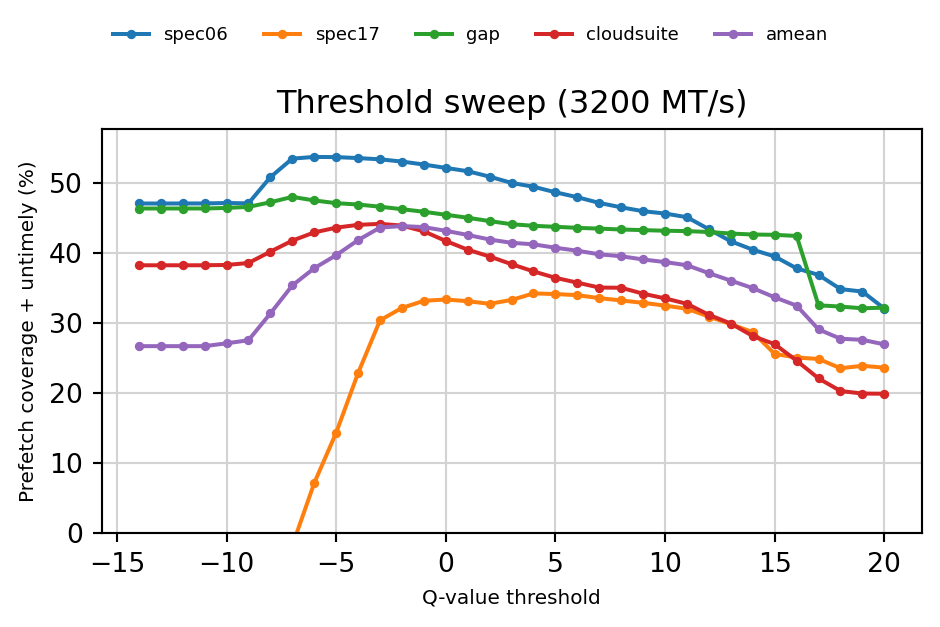

In [25]:
plot_threshold_sweep(
    degreedyn_1core_dfs[3200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_coverage_untimely",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch coverage + untimely (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    ymin=0,
)
plt.savefig("threshold_sweep_3200_coverage_untimely.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_coverage_untimely.png", dpi=dpi, bbox_inches="tight")

### Overpredictions

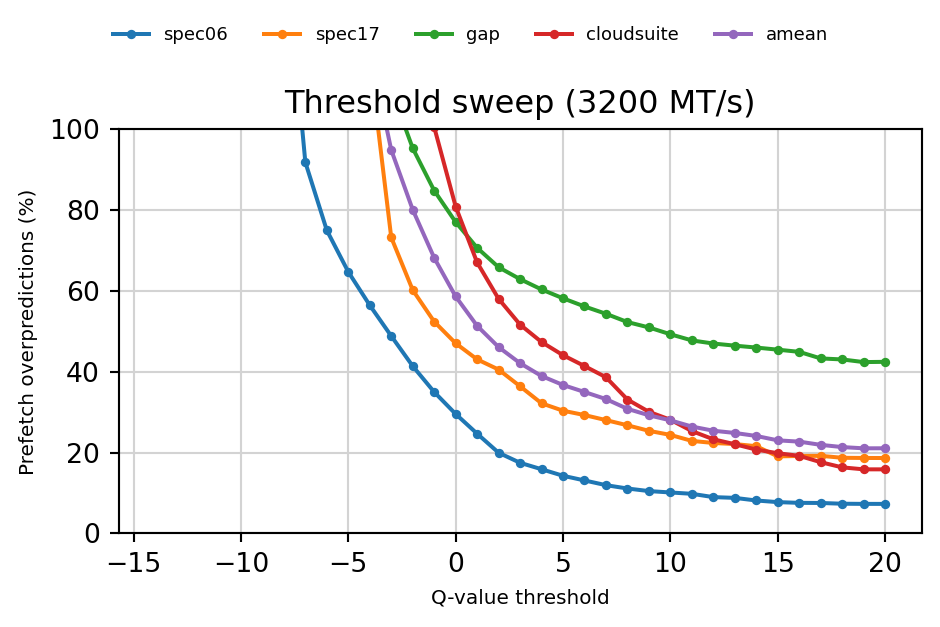

In [26]:
plot_threshold_sweep(
    degreedyn_1core_dfs[3200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_overpredictions",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch overpredictions (%)",
    suptitle="Threshold sweep (3200 MT/s)",
    ymin=0, ymax=100,
)
plt.savefig("threshold_sweep_3200_overpredictions.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_overpredictions.png", dpi=dpi, bbox_inches="tight")

## 200 MT/s

### IPC improvement

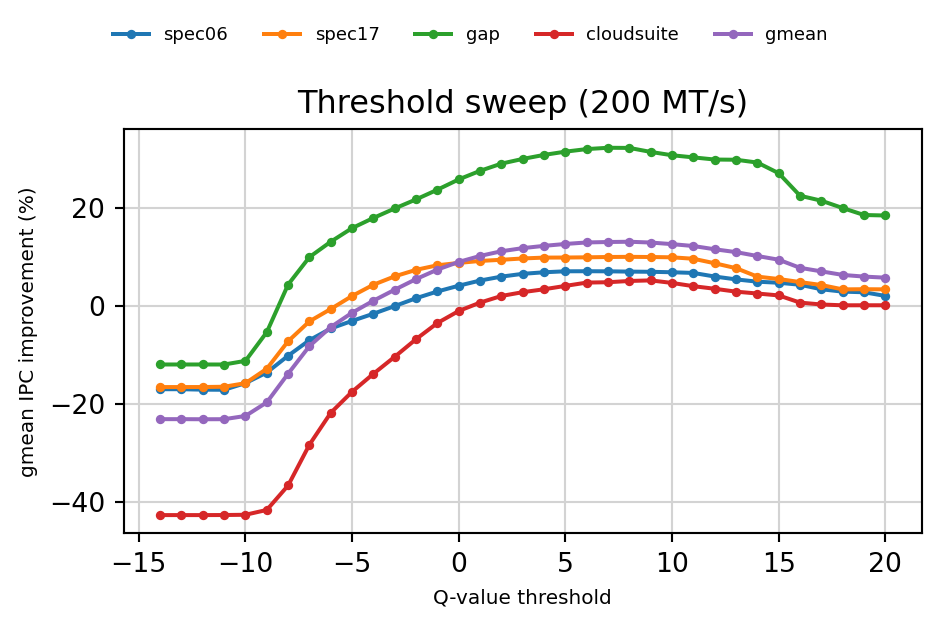

In [27]:
plot_threshold_sweep(
    degreedyn_1core_dfs[200], 
    suites=suites, 
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
    #ymin=0,
)
plt.savefig("threshold_sweep_200_ipc.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc.png", dpi=dpi, bbox_inches="tight")

#### spec06

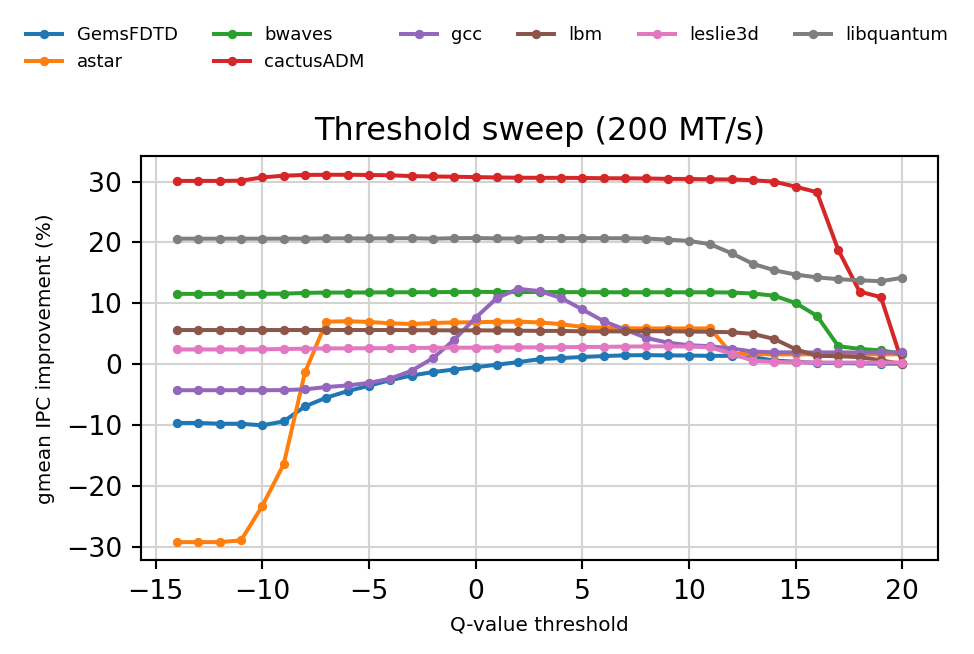

In [28]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[200], 
    suite="spec06",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
    benchmarks=["GemsFDTD", "astar", "bwaves", "cactusADM", "gcc", "lbm", "leslie3d", "libquantum"],
)
plt.savefig("threshold_sweep_200_ipc_spec06.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc_spec06.png", dpi=dpi, bbox_inches="tight")

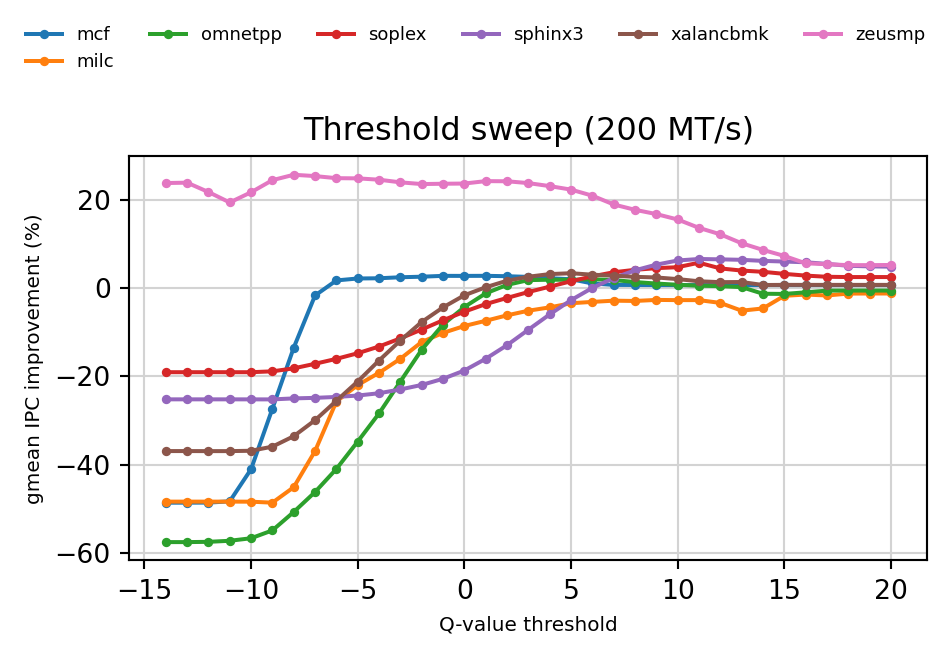

In [29]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[200], 
    suite="spec06",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
    benchmarks=["mcf", "milc", "omnetpp", "soplex", "sphinx3", "xalancbmk", "zeusmp"],
)
plt.savefig("threshold_sweep_200_ipc_spec06_pt2.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc_spec06_pt2.png", dpi=dpi, bbox_inches="tight")

#### spec17

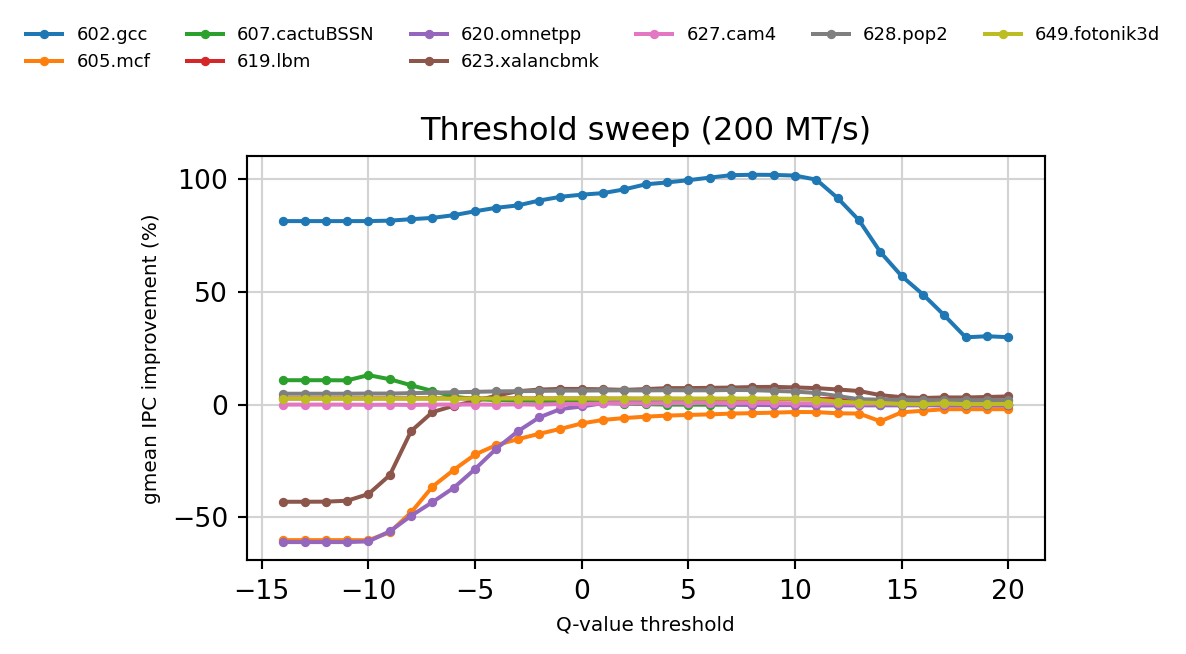

In [30]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[200], 
    suite="spec17",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
)
plt.savefig("threshold_sweep_200_ipc_spec17.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc_spec17.png", dpi=dpi, bbox_inches="tight")

#### gap

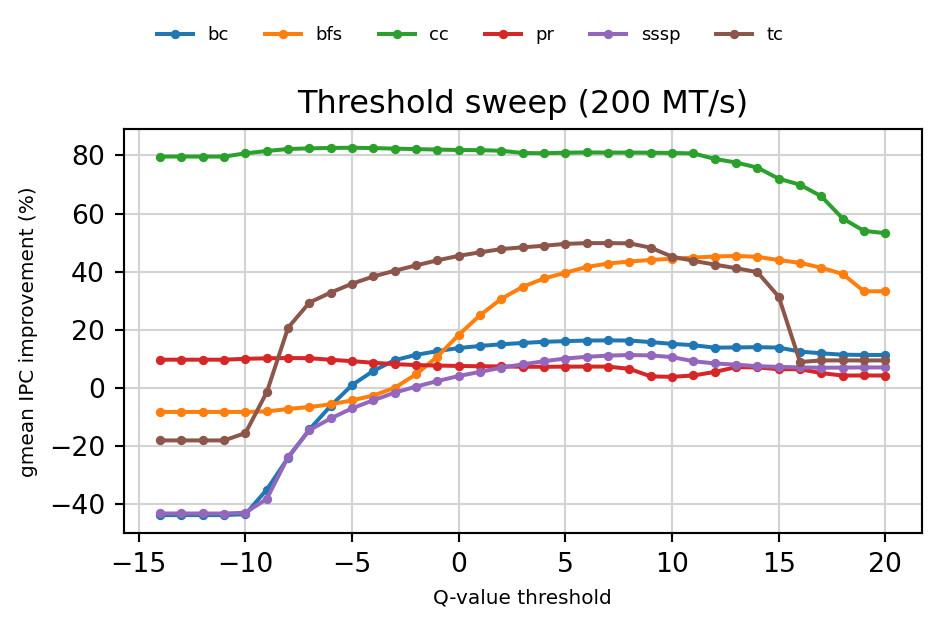

In [31]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[200], 
    suite="gap",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
)
plt.savefig("threshold_sweep_200_ipc_gap.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc_gap.png", dpi=dpi, bbox_inches="tight")

#### cloudsuite

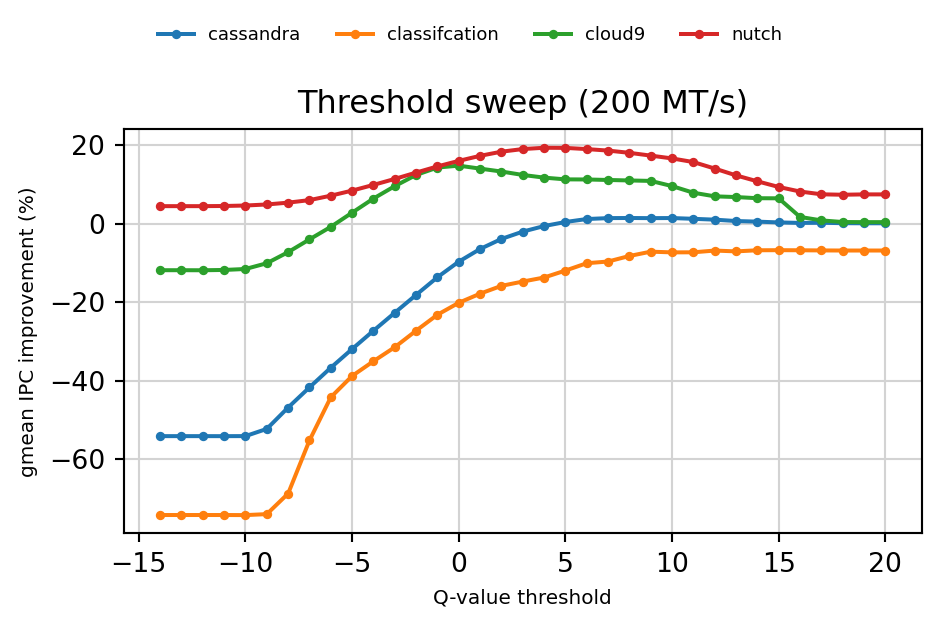

In [32]:
plot_threshold_sweep_benchmarks(
    degreedyn_1core_dfs[200], 
    suite="cloudsuite",
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="gmean IPC improvement (%)",
    suptitle="Threshold sweep (200 MT/s)",
)
plt.savefig("threshold_sweep_200_ipc_cloudsuite.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_ipc_cloudsuite.png", dpi=dpi, bbox_inches="tight")

### Coverage

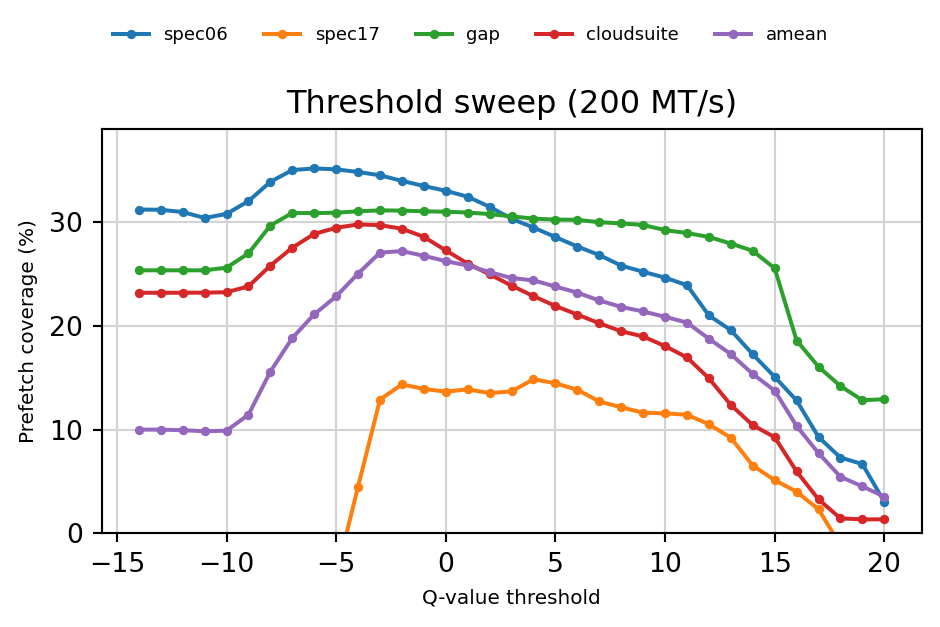

In [33]:
plot_threshold_sweep(
    degreedyn_1core_dfs[200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_coverage",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch coverage (%)",
    suptitle="Threshold sweep (200 MT/s)",
    ymin=0,
)
plt.savefig("threshold_sweep_200_coverage.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_coverage.png", dpi=dpi, bbox_inches="tight")

### Untimely coverage

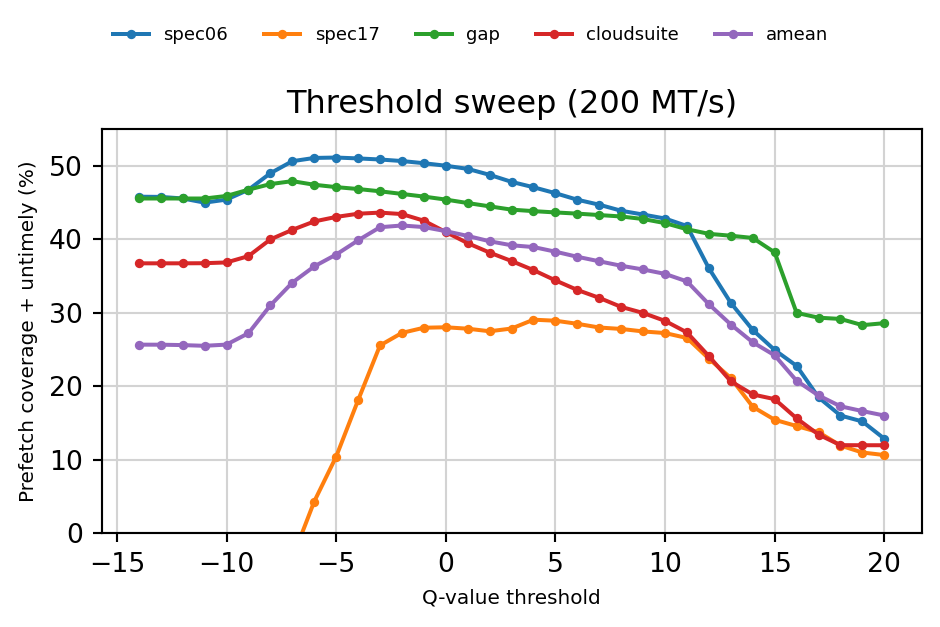

In [34]:
plot_threshold_sweep(
    degreedyn_1core_dfs[200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_coverage_untimely",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch coverage + untimely (%)",
    suptitle="Threshold sweep (200 MT/s)",
    ymin=0,
)
plt.savefig("threshold_sweep_200_coverage_untimely.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_coverage_untimely.png", dpi=dpi, bbox_inches="tight")

### Overpredictions

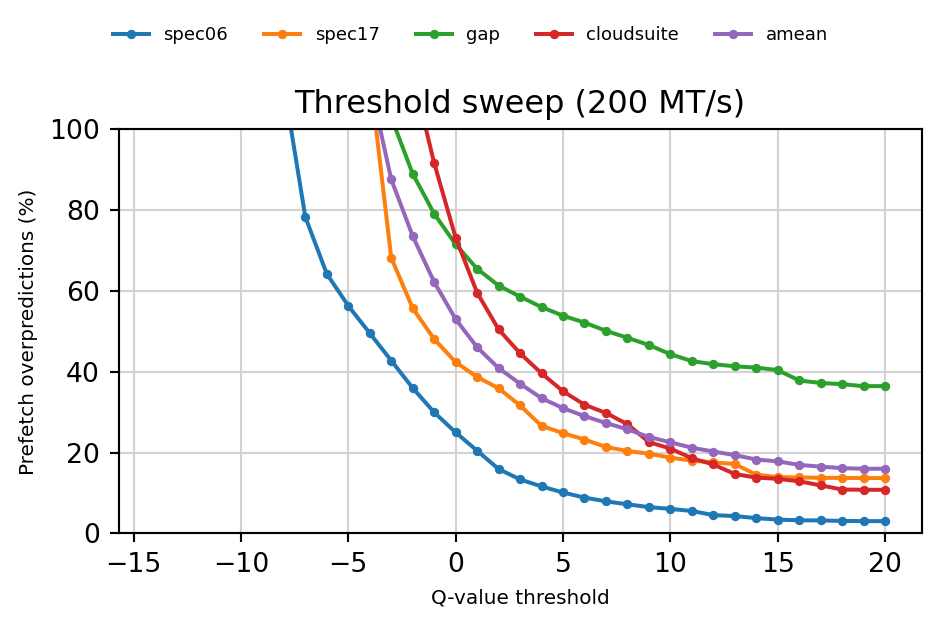

In [35]:
plot_threshold_sweep(
    degreedyn_1core_dfs[200], 
    suites=suites,
    statistic_name="cache.L2C.amean.prefetch_overpredictions",
    #colors=degreedyn_1core_colors, 
    #markers=degreedyn_1core_markers,
    legend_kwargs=degreedyn_1core_legend_kwargs,
    ylabel="Prefetch overpredictions (%)",
    suptitle="Threshold sweep (200 MT/s)",
    ymin=0, ymax=100,
)
plt.savefig("threshold_sweep_200_overpredictions.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_overpredictions.png", dpi=dpi, bbox_inches="tight")

# Baseline comparison

In [194]:
baseline_df_3200 = {
    "Cygnus (Best Global Static, -2)": studies[f"cygnus_qvthreshold__3200"][f"cygnus__-2"],
    "Cygnus (Original Global Static, -3)": studies[f"cygnus_qvthreshold__3200"][f"cygnus__-3"],
    "SPP+PPF": studies[f"prefetchers__3200"][f"spp_ppf"],
    "Pythia": studies[f"prefetchers__3200"][f"pythia"],
    "my5": studies[f"prefetchers__3200"][f"my5"],
}
baseline_df_200 = {
    "Cygnus (Best Global Static, 8)": studies[f"cygnus_qvthreshold__200"][f"cygnus__8"],
    "Cygnus (Original Global Static, -3)": studies[f"cygnus_qvthreshold__200"][f"cygnus__-3"],
    "SPP+PPF": studies[f"prefetchers__200"][f"spp_ppf"],
    "Pythia": studies[f"prefetchers__200"][f"pythia"],
    "my5": studies[f"prefetchers__200"][f"my5"],
}

baseline_colors = {
    "Cygnus (Best Per-Trace Static)": colormaps["Set3"](0),
    "Cygnus (Best Global Static, -2)": colormaps["Set3"](0),
    "Cygnus (Best Global Static, 8)": colormaps["Set3"](0),
    "Cygnus (Original Global Static, -3)": colormaps["Set3"](0),
    "my5"    : colormaps["Set3"](9),
    "Pythia" : colormaps["Set3"](2),
    "SPP+PPF": colormaps["Set3"](6),
}
baseline_hatches = {
    "Cygnus (Best Per-Trace Static)": "xxxx",
    "Cygnus (Best Global Static, -2)": "////",
    "Cygnus (Best Global Static, 8)": "////",
    "Cygnus (Original Global Static, -3)": "",
    "my5"    : "",
    "Pythia" : "",
    "SPP+PPF": "",
}
baseline_legend_kwargs = {
    "ncol": 3,
    "fontsize": 6.75,
    "loc": "lower center",
    "bbox_to_anchor": (0.5, 1.0),
    "framealpha": 0,
}
baseline_label_kwargs = {
    "rotation": 0,
    "ha": "center",
    "fontsize": 7,
}

## 3200 MT/s

### IPC improvement

In [195]:
reload(plot)
baseline_df_3200__ipc = plot.get_suite_table(baseline_df_3200, "cpu.gmean.ipc_improvement", 
                                             suites=suites, add_mean=True)
thresholds = [int(exp.split("_")[-1]) for exp in studies[f"cygnus_qvthreshold__{bandwidth}"].study.experiments]
cygnus_oracle_3200 = create_oracle(
    studies["cygnus_qvthreshold__3200"].tabler,
    "cpu.gmean.ipc_improvement",
    oracle_level="mix",
    oracle_method="max",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_3200__ipc_overall = get_oracle_stat(
    studies["cygnus_qvthreshold__3200"].tabler,
    cygnus_oracle_3200,
    "overall",
    "cpu.gmean.ipc_improvement",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_3200__ipc_suite = get_oracle_stat(
    studies["cygnus_qvthreshold__3200"].tabler,
    cygnus_oracle_3200,
    "suite",
    "cpu.gmean.ipc_improvement",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_3200__ipc_suite["gmean"] = cygnus_oracle_3200__ipc_overall
cygnus_oracle_3200__ipc_suite = cygnus_oracle_3200__ipc_suite.rename(index={"Oracle": "Cygnus (Best Per-Trace Static)"})

baseline_df_3200__ipc = pd.concat([
    cygnus_oracle_3200__ipc_suite,
    baseline_df_3200__ipc,
])
baseline_df_3200__ipc

/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)


,gap,spec06,spec17,cloudsuite,gmean
Cygnus (Best Per-Trace Static),23.337722,37.812217,26.908574,14.390129,25.333102
"Cygnus (Best Global Static, -2)",21.877458,34.252495,25.804238,10.741114,22.874702
"Cygnus (Original Global Static, -3)",22.131828,34.157117,25.502473,10.803229,22.860370
SPP+PPF,18.423648,32.208799,22.860580,7.766227,19.990955
Pythia,19.632290,26.610409,20.813901,7.597408,18.456565
my5,18.328960,29.635344,21.920663,8.431924,19.333461


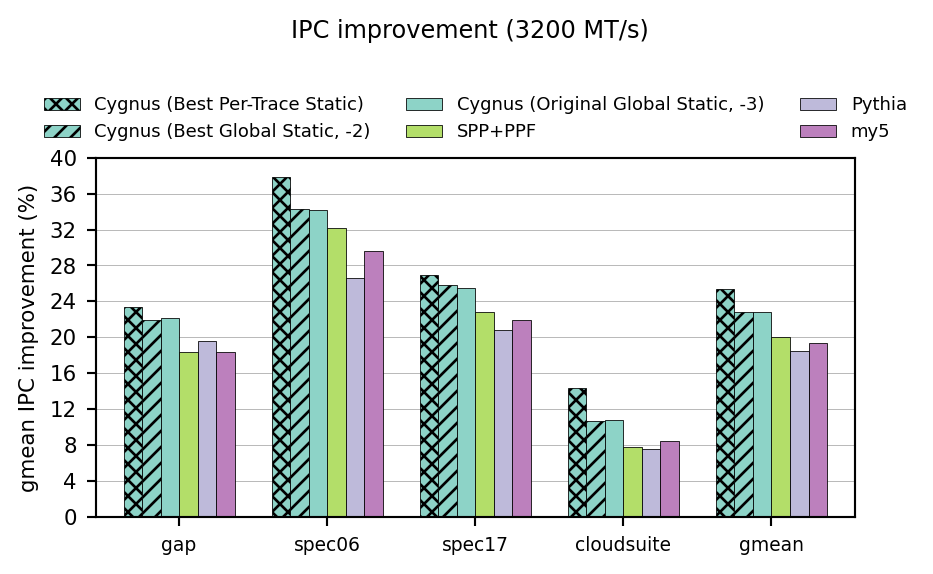

In [203]:
reload(plot)                                             
plot.plot_table(baseline_df_3200__ipc,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    add_suptitle=True,
    suptitle="IPC improvement (3200 MT/s)",
    add_xlabel=False,
    ylabel="gmean IPC improvement (%)",
    ylim=(0, 40),
    ytick_distance=4,
    dpi=192, figsize=(5, 3))
plt.savefig("threshold_sweep_3200_baseline_ipc.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_baseline_ipc.pdf", dpi=dpi, bbox_inches="tight")

### Prefetch classification

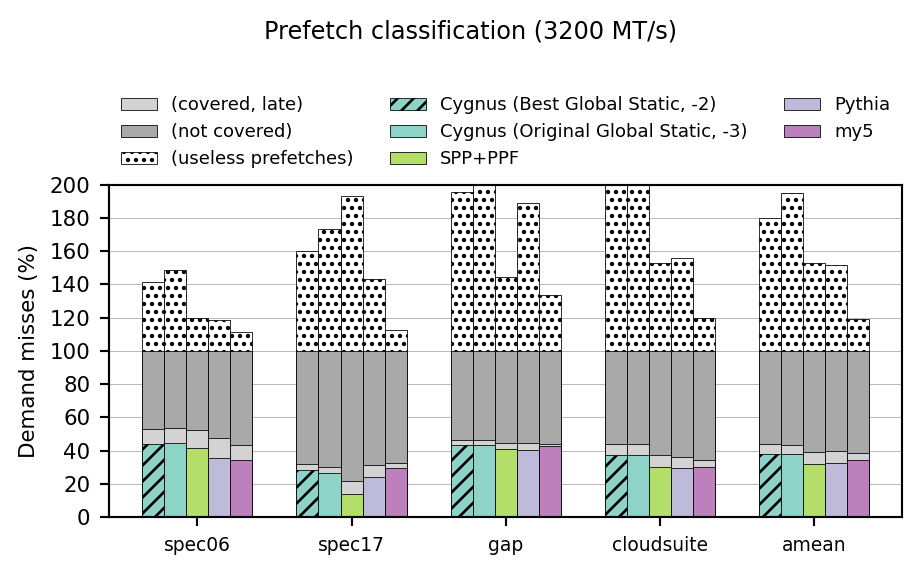

In [197]:
reload(plot)
plot.plot_suite_overpredictions(
    baseline_df_3200,
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch classification (3200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 200),
    ytick_distance=20,
    dpi=192, figsize=(5, 3))
plt.savefig("threshold_sweep_3200_baseline_classification.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_3200_baseline_classification.pdf", dpi=dpi, bbox_inches="tight")

## 200 MT/s

### IPC improvement

In [198]:
reload(plot)
baseline_df_200__ipc = plot.get_suite_table(baseline_df_200, "cpu.gmean.ipc_improvement", 
                                             suites=suites, add_mean=True)
thresholds = [int(exp.split("_")[-1]) for exp in studies[f"cygnus_qvthreshold__{bandwidth}"].study.experiments]
cygnus_oracle_200 = create_oracle(
    studies["cygnus_qvthreshold__200"].tabler,
    "cpu.gmean.ipc_improvement",
    oracle_level="mix",
    oracle_method="max",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_200__ipc_overall = get_oracle_stat(
    studies["cygnus_qvthreshold__200"].tabler,
    cygnus_oracle_200,
    "overall",
    "cpu.gmean.ipc_improvement",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_200__ipc_suite = get_oracle_stat(
    studies["cygnus_qvthreshold__200"].tabler,
    cygnus_oracle_200,
    "suite",
    "cpu.gmean.ipc_improvement",
    oracle_experiments=[f"cygnus__{t}" for t in thresholds]
)
cygnus_oracle_200__ipc_suite["gmean"] = cygnus_oracle_200__ipc_overall
cygnus_oracle_200__ipc_suite = cygnus_oracle_200__ipc_suite.rename(index={"Oracle": "Cygnus (Best Per-Trace Static)"})

baseline_df_200__ipc = pd.concat([
    cygnus_oracle_200__ipc_suite,
    baseline_df_200__ipc,
])
baseline_df_200__ipc

/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)
/tmp/ipykernel_3846137/2073359622.py:134: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  mix_df["Oracle"] = mix_df.lookup(oracle_s.index, oracle_s.values)


,gap,spec06,spec17,cloudsuite,gmean
Cygnus (Best Per-Trace Static),33.530470,9.627747,12.645279,7.293700,15.331256
"Cygnus (Best Global Static, 8)",32.250233,7.045087,10.055331,5.138191,13.131538
"Cygnus (Original Global Static, -3)",19.915836,0.025962,6.083281,-10.298429,3.361563
SPP+PPF,28.332860,6.158251,10.074553,-0.632222,10.485691
Pythia,28.220061,6.634564,9.004599,0.782206,10.705874
my5,27.666547,7.864061,12.803516,4.676752,12.922813


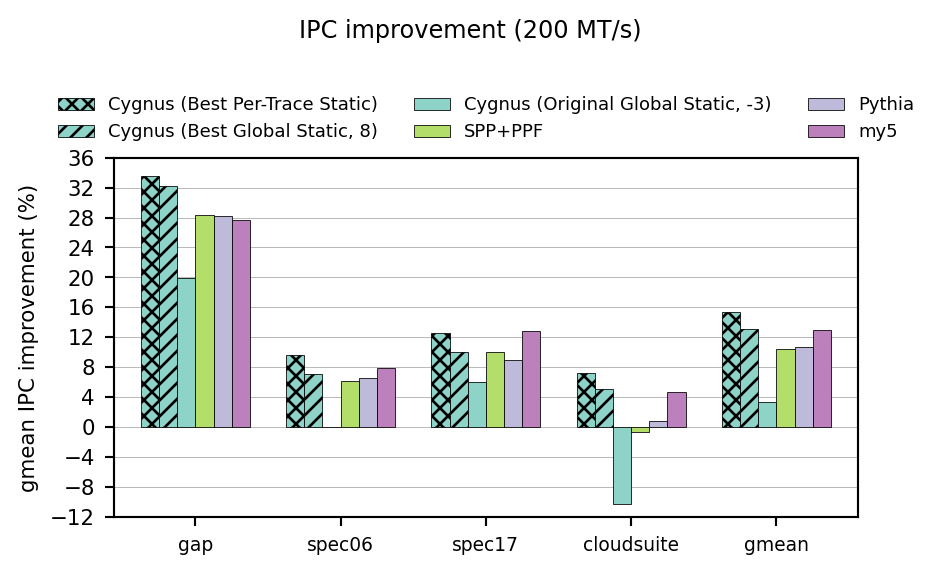

In [204]:
reload(plot)
plot.plot_table(baseline_df_200__ipc,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    add_suptitle=True,
    suptitle="IPC improvement (200 MT/s)",
    add_xlabel=False,
    ylabel="gmean IPC improvement (%)",
    ylim=(-12, 36),
    ytick_distance=4,
    dpi=192, figsize=(5, 3))
plt.savefig("threshold_sweep_200_baseline_ipc.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_baseline_ipc.pdf", dpi=dpi, bbox_inches="tight")

### Prefetch classification

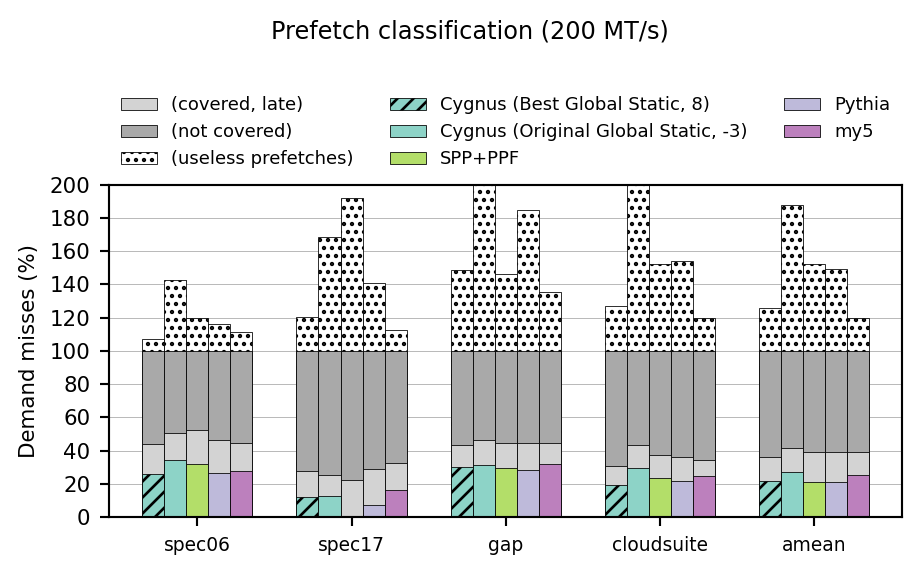

In [200]:
reload(plot)
plot.plot_suite_overpredictions(
    baseline_df_200,
    suites=suites,
    add_mean=True,
    colors=baseline_colors,
    hatches=baseline_hatches,
    legend_kwargs=baseline_legend_kwargs,
    label_kwargs=baseline_label_kwargs,
    suptitle="Prefetch classification (200 MT/s)",
    add_suptitle=True,
    add_xlabel=False,
    ylim=(0, 200),
    ytick_distance=20,
    dpi=192, figsize=(5, 3))
plt.savefig("threshold_sweep_200_baseline_classification.png", dpi=dpi, bbox_inches="tight")
plt.savefig("threshold_sweep_200_baseline_classification.pdf", dpi=dpi, bbox_inches="tight")